In [19]:
import os
import sys
import torch
import time
import shutil
from torchvision.transforms import ToPILImage
from os.path import join

base_directory = "../"
sys.path.insert(0, base_directory)
from labml import monit
from stable_diffusion2.constants import ModelsPathTree
from stable_diffusion2.utils.utils import *
from stable_diffusion2.utils.model import *
from stable_diffusion2.stable_diffusion import StableDiffusion

output_base_dir = join(base_directory, "./output/sd2-notebook/")
output_directory = join(output_base_dir, "denoising/")

try:
    shutil.rmtree(output_directory)
except Exception as e:
    print(e, "\n", "Creating the path...")
    os.makedirs(output_directory, exist_ok=True)
else:
    os.makedirs(output_directory, exist_ok=True)


def to_pil(image):
    return ToPILImage()(torch.clamp((image + 1.0) / 2.0, min=0.0, max=1.0))

In [4]:
device = get_device()
pt = ModelsPathTree(base_directory=base_directory)

INFO: Using CUDA device: NVIDIA GeForce RTX 3080 Ti


In [5]:
# initialize an empty stable diffusion class
stable_diffusion = StableDiffusion(device=device)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 11086 MiB
Used: 1201 MiB


In [6]:
# initialize an empty latent diffusion model; it returns self.model
# then load the clip text embedder from the path `pt.embedder_path` with .load_clip_embedder()
# it returns the clip embedder, so you can chain a .load_submodels() to load the text embedder submodels

stable_diffusion.quick_initialize().load_clip_embedder(**pt.embedder).load_submodels(
    **pt.embedder_submodels
)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 10124 MiB
Used: 2163 MiB


In [7]:
stable_diffusion.model.clip_embedder

CLIPTextEmbedder(
  (transformer): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768,

In [8]:
# get the embedding for a prompt
prompt_embedding = stable_diffusion.model.clip_embedder(
    ["A woman with flowers in her hair in a courtyard, in the style of Frank Frazetta"]
)
null_prompt = stable_diffusion.model.clip_embedder([""])

In [9]:
get_memory_status()
prompt_embedding.shape, null_prompt.shape

Total: 12287 MiB
Free: 9620 MiB
Used: 2667 MiB


(torch.Size([1, 77, 768]), torch.Size([1, 77, 768]))

In [10]:
# we don't need the embedder anymore, so we can unload it
stable_diffusion.model.unload_clip_embedder()
get_memory_status()

Total: 12287 MiB
Free: 9620 MiB
Used: 2667 MiB


In [11]:
# let's save the prompt embedding
torch.save(prompt_embedding, join(output_directory, "prompt_embedding.pt"))
torch.save(null_prompt, join(output_directory, "null_prompt.pt"))

In [20]:
# the latent diffusion class has a method to load the unet, since it is a submodel of it. it returns the unet model, wrapped in a DiffusionWrapper class.
# it is accessible as self.model.model or through the alias self.model.unet
stable_diffusion.model.load_unet(**pt.unet)
get_memory_status()
stable_diffusion.model.unet

Total: 12287 MiB
Free: 2974 MiB
Used: 9313 MiB


In [21]:
# sample a latent representation, we know beforehand that the latent space is shaped as (1, 4, 64, 64)
initial_latent = torch.randn(1, 4, 64, 64, device=device)
get_memory_status()

Total: 12287 MiB
Free: 2974 MiB
Used: 9313 MiB


In [22]:
# define a timestep for this sample
time_step = torch.tensor([15.0]).to(device)
time_step.shape

torch.Size([1])

In [23]:
@torch.no_grad()
def sample(
    stable_diffusion: StableDiffusion,
    shape: List[int],
    cond: torch.Tensor,
    repeat_noise: bool = False,
    temperature: float = 1.0,
    x_last: Optional[torch.Tensor] = None,
    uncond_scale: float = 1.0,
    uncond_cond: Optional[torch.Tensor] = None,
    skip_steps: int = 0,
    noise_fn=torch.randn,
):
    """
    ### Sampling Loop
    :param shape: is the shape of the generated images in the
        form `[batch_size, channels, height, width]`
    :param cond: is the conditional embeddings $c$
    :param temperature: is the noise temperature (random noise gets multiplied by this)
    :param x_last: is $x_{\tau_S}$. If not provided random noise will be used.
    :param uncond_scale: is the unconditional guidance scale $s$. This is used for
        $\epsilon_\theta(x_t, c) = s\epsilon_\text{cond}(x_t, c) + (s - 1)\epsilon_\text{cond}(x_t, c_u)$
    :param uncond_cond: is the conditional embedding for empty prompt $c_u$
    :param skip_steps: is the number of time steps to skip $i'$. We start sampling from $S - i'$.
        And `x_last` is then $x_{\tau_{S - i'}}$.
    """
    # Get device and batch size
    latents = []
    device = stable_diffusion.sampler.model.device
    bs = shape[0]
    # Get $x_{\tau_S}$
    x = x_last if x_last is not None else noise_fn(shape, device=device)
    latents.append(x)
    # Time steps to sample at $\tau_{S - i'}, \tau_{S - i' - 1}, \dots, \tau_1$
    time_steps = np.flip(stable_diffusion.sampler.time_steps)[skip_steps:]
    for i, step in monit.enum("Sample", time_steps):
        # Index $i$ in the list $[\tau_1, \tau_2, \dots, \tau_S]$
        index = len(time_steps) - i - 1
        # Time step $\tau_i$
        ts = x.new_full((bs,), step, dtype=torch.long)
        # Sample $x_{\tau_{i-1}}$
        x, pred_x0, e_t = stable_diffusion.sampler.p_sample(
            x,
            cond,
            ts,
            step,
            index=index,
            repeat_noise=repeat_noise,
            temperature=temperature,
            uncond_scale=uncond_scale,
            uncond_cond=uncond_cond,
            noise_fn=noise_fn,
        )
        latents.append(x)
    # Return $x_0$
    return latents

In [25]:
autocast = get_autocast()
with autocast:
    latents = sample(
        stable_diffusion=stable_diffusion,
        shape=[1, 4, 64, 64],
        cond=prompt_embedding,
        uncond_cond=null_prompt,
        x_last=initial_latent,
        noise_fn=torch.randn,
    )

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

In [34]:
grid = torch.cat(latents[1:], dim=0)
grid.shape

torch.Size([50, 4, 64, 64])

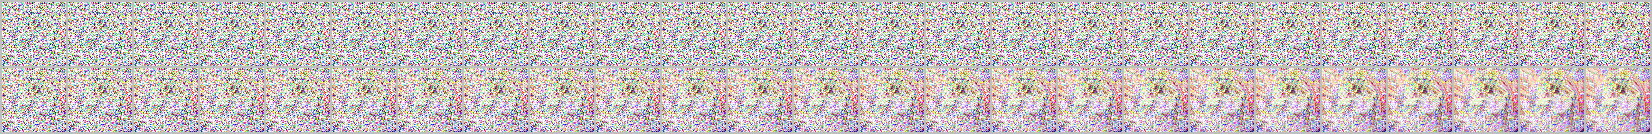

In [36]:
grid = torchvision.utils.make_grid(
    grid,
    nrow=5,
    normalize=False,
    range=(-1, 1),
    scale_each=True,
    pad_value=0,
)
dim_grid_image = to_pil(grid)
dim_grid_image.save(join(output_directory, f"unet_output.png"))
dim_grid_image

In [40]:
stable_diffusion.model.unload_submodels()
torch.cuda.empty_cache()
get_memory_status()

Total: 12287 MiB
Free: 6000 MiB
Used: 6287 MiB


In [45]:
to_be_decoded = latents[-1]

In [46]:
stable_diffusion.model.load_autoencoder(
    **pt.autoencoder).load_decoder(**pt.decoder)
get_memory_status()

Autoencoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\autoencoder.ckpt
Decoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\decoder.ckpt
Total: 12287 MiB
Free: 5620 MiB
Used: 6667 MiB


In [47]:
stable_diffusion.decode_image(to_be_decoded)

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 12.00 GiB total capacity; 11.01 GiB already allocated; 0 bytes free; 11.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF